In [1]:
import os
import torch
import time
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
from data.nus_mapping import compile_data_mapping
from Our.LSS_model_da import LiftSplatShoot_mask_mix
from tools import *
from torch.optim import SGD, AdamW, Adam
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from Our.confusion import BinaryConfusionMatrix, singleBinary

In [8]:
version =  'v1.0-mini'
grid_conf = {
    'xbound': [-30.0, 30.0, 0.15],
    'ybound': [-15.0, 15.0, 0.15],
    'zbound': [-10.0, 10.0, 20.0],
    'dbound': [4.0, 45.0, 1.0],
}
data_aug_conf = {'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
                            'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'],
                    'Ncams': 6, 'up_scale': 4, 'H': 900, 'W': 1600,
                    'rand_resize': True, 'resize_lim': (0.20, 0.235), 'bot_pct_lim': (0.0, 0.22),
                    'rand_flip': True,
                    'rot': True, 'rot_lim': (-5.4, 5.4),
                    'color_jitter': True, 'color_jitter_conf': [0.2, 0.2, 0.2, 0.1],
                    'GaussianBlur': False, 'gaussion_c': (0, 2),
                    'final_dim': (128, 352),  # (224,480),#
                    'Aug_mode': 'hard',  # 'simple',#
                    'backbone': "efficientnet-b0",
                    }
b = 10
lr = 1e-3*b/4
source_name_list = ['boston']
target_name_list = ['singapore']
n = 0
source = source_name_list[n]
target = target_name_list[n]


logdir='./ours_mapping_' + source+'_'+target+'_2'
if not os.path.exists(logdir):
    os.mkdir(logdir)

logging.basicConfig(filename=os.path.join(logdir, "results.log"),
                    filemode='w',
                    format='%(asctime)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)
logging.getLogger('shapely.geos').setLevel(logging.CRITICAL)
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(sys.stdout))

In [9]:
dataroot='./nuscenes_mini'
domain_gap=True
nsweeps=3
bsz=b
nworkers=6
lr=lr
weight_decay=1e-2
nepochs=24

In [10]:
logger.info("Lidar Sup + Mini BEV Sup")
strainloader, ttrainloader, tvalloader = compile_data_mapping(version, dataroot, data_aug_conf, grid_conf, nsweeps, domain_gap=True
                                                              , source=source, target=target, bsz=b, nworkers=6, flip=True)

straingenerator = iter(strainloader)
ttraingenerator = iter(ttrainloader)

datalen = len(strainloader) if len(strainloader) > len(ttrainloader) else len(ttrainloader)

Lidar Sup + Mini BEV Sup
Lidar Sup + Mini BEV Sup
163 hard
True
160 hard
True
81 hard
True
len of strainloader and ttrainloader:  16 16 16


In [11]:
imgs, rots, trans, intrins, post_rots, post_trans, lidars, binimgs_s, seg_mask_s = next(straingenerator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

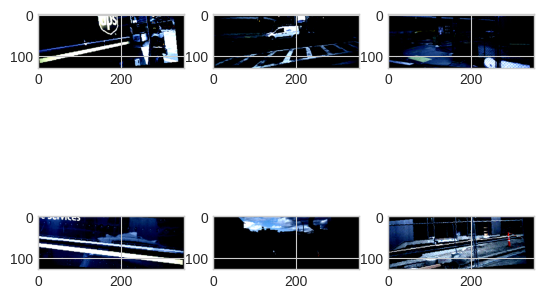

In [17]:
rnd_idx = np.random.randint(0, len(imgs))

plt.subplot(231)
plt.imshow(imgs[rnd_idx][0].permute(1, 2, 0).cpu().numpy())
plt.subplot(232)
plt.imshow(imgs[rnd_idx][1].permute(1, 2, 0).cpu().numpy())
plt.subplot(233)
plt.imshow(imgs[rnd_idx][2].permute(1, 2, 0).cpu().numpy())
plt.subplot(234)
plt.imshow(imgs[rnd_idx][3].permute(1, 2, 0).cpu().numpy())
plt.subplot(235)
plt.imshow(imgs[rnd_idx][4].permute(1, 2, 0).cpu().numpy())
plt.subplot(236)
plt.imshow(imgs[rnd_idx][5].permute(1, 2, 0).cpu().numpy())
plt.show()

In [39]:
rots.shape, trans.shape, intrins.shape, post_rots.shape, post_trans.shape, lidars.shape

(torch.Size([10, 6, 3, 3]),
 torch.Size([10, 6, 3]),
 torch.Size([10, 6, 3, 3]),
 torch.Size([10, 6, 3, 3]),
 torch.Size([10, 6, 3]),
 torch.Size([10, 6, 41, 16, 44]))

In [31]:
binimgs_s['iou'].shape, binimgs_s['index'].shape, binimgs_s['car'].shape, binimgs_s['seg_mask'].shape

(torch.Size([10, 4, 400, 200]),
 torch.Size([10, 400, 200]),
 torch.Size([10, 400, 200]),
 torch.Size([10, 2, 400, 200]))

In [47]:
# Visualize BEV IoU map
plt.figure(figsize=(10, 8))
plt.imshow(binimgs_s['iou'][rnd_idx].permute(1, 2, 0).cpu().numpy(), cmap='viridis')
plt.colorbar(label='IoU Value')
plt.title(f'BEV IoU Map - Sample {rnd_idx} from {source}')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.tight_layout()
plt.show()

# Print shape information
print(f"BEV IoU map shape: {binimgs_s['iou'].shape}")
print(f"Value range: [{binimgs_s['iou'].min().item():.4f}, {binimgs_s['iou'].max().item():.4f}]")

ValueError: Unsupported dtype

<Figure size 1000x800 with 2 Axes>

BEV IoU map shape: torch.Size([10, 4, 400, 200])
Value range: [0.0000, 1.0000]


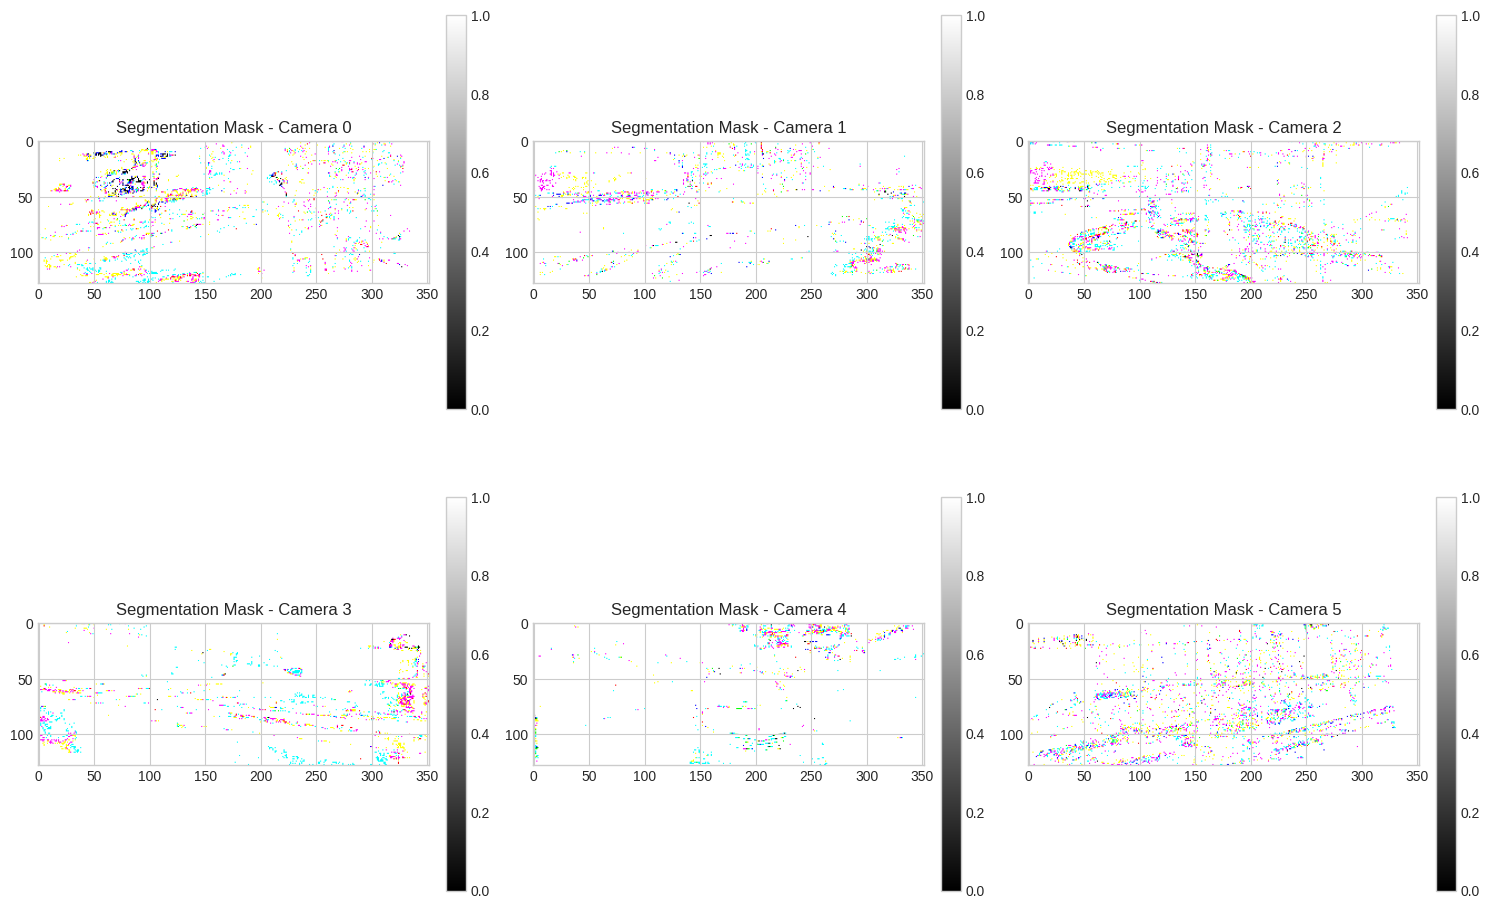

Segmentation mask shape: torch.Size([10, 6, 6, 128, 352, 3])
Showing masks for sample index: 2


In [44]:
# Visualize the segmentation masks for all camera views
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Use the same random index as used for displaying camera images
for i in range(6):  # For all 6 cameras
    mask_vis = seg_mask_s[rnd_idx][i][0].cpu().numpy()
    im = axs[i].imshow(mask_vis, cmap='gray')
    axs[i].set_title(f'Segmentation Mask - Camera {i}')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Show shape information
print(f"Segmentation mask shape: {seg_mask_s.shape}")
print(f"Showing masks for sample index: {rnd_idx}")